In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

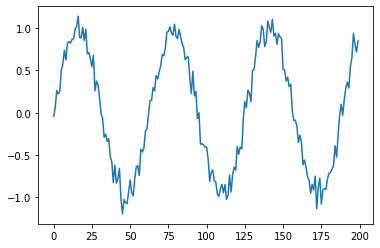

In [2]:
# Create the synthetic dataset
series = np.sin(0.1 * np.arange(200))
series = series + np.random.randn(200) * 0.1 # add noise

# plot ot
plt.plot(series)
plt.show();

In [3]:
# Try to use the last T values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T] # Get the set of T values
    X.append(x) # append those values into the dataset X
    y = series[t+T] # get the next value as the target
    Y.append(y) # add the target value to Y

In [4]:
# Make the arrays the correct shape (N x T x D)
X_arr = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
y_arr = np.array(Y)
N = len(X_arr)
print('X_arr shape:', X_arr.shape)
print('y_arr shape:', y_arr.shape)

X_arr shape: (190, 10, 1)
y_arr shape: (190,)


In [5]:
# Split into train and test sets
# Don't use train_test_split
# Model needs to make predictions, to train set is the first half, and test set is the second half
# Can use points in between the train set for the test set
X_train = X_arr[:-N//2]
y_train = y_arr[:-N//2]
X_test = X_arr[-N//2:]
y_test = y_arr[-N//2:]

In [6]:
# Define the layers of the model
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation='tanh')(i) # Defailt activation is activation='tanh'
x = Dense(1)(x)

In [7]:
# Build the model
model = Model(i, x)

In [8]:
# Define how the model should be trained
model.compile(optimizer=Adam(lr=0.1),
              loss='mse')

In [9]:
# Train the model
# Train the mdoel
result = model.fit(x=X_train, y=y_train, # train on the first half of the dataset (don't use train_test_split)
                   epochs=100,
                   validation_data=(X_test, y_test)) # test on the second half of the dataset 

Train on 95 samples, validate on 95 samples
Epoch 1/100
95/95 [==============================] - 1s 11ms/sample - loss: 0.2374 - val_loss: 0.0814
Epoch 2/100
95/95 [==============================] - 0s 337us/sample - loss: 0.0578 - val_loss: 0.0373
Epoch 3/100
95/95 [==============================] - 0s 358us/sample - loss: 0.0441 - val_loss: 0.0581
Epoch 4/100
95/95 [==============================] - 0s 358us/sample - loss: 0.0421 - val_loss: 0.0351
Epoch 5/100
95/95 [==============================] - 0s 369us/sample - loss: 0.0376 - val_loss: 0.0349
Epoch 6/100
95/95 [==============================] - 0s 358us/sample - loss: 0.0319 - val_loss: 0.0329
Epoch 7/100
95/95 [==============================] - 0s 368us/sample - loss: 0.0276 - val_loss: 0.0306
Epoch 8/100
95/95 [==============================] - 0s 337us/sample - loss: 0.0241 - val_loss: 0.0257
Epoch 9/100
95/95 [==============================] - 0s 337us/sample - loss: 0.0261 - val_loss: 0.0257
Epoch 10/100
95/95 [==========

95/95 [==============================] - 0s 315us/sample - loss: 0.0126 - val_loss: 0.0239
Epoch 80/100
95/95 [==============================] - 0s 312us/sample - loss: 0.0145 - val_loss: 0.0214
Epoch 81/100
95/95 [==============================] - 0s 334us/sample - loss: 0.0135 - val_loss: 0.0213
Epoch 82/100
95/95 [==============================] - 0s 331us/sample - loss: 0.0133 - val_loss: 0.0207
Epoch 83/100
95/95 [==============================] - 0s 321us/sample - loss: 0.0116 - val_loss: 0.0221
Epoch 84/100
95/95 [==============================] - 0s 322us/sample - loss: 0.0145 - val_loss: 0.0218
Epoch 85/100
95/95 [==============================] - 0s 329us/sample - loss: 0.0133 - val_loss: 0.0225
Epoch 86/100
95/95 [==============================] - 0s 324us/sample - loss: 0.0157 - val_loss: 0.0250
Epoch 87/100
95/95 [==============================] - 0s 320us/sample - loss: 0.0140 - val_loss: 0.0219
Epoch 88/100
95/95 [==============================] - 0s 337us/sample - loss:

In [10]:
# Print the results
print("Train mse:", model.evaluate(x=X_train, y=y_train, verbose=0));
print("Test mse:", model.evaluate(x=X_test, y=y_test, verbose=0));

Train mse: 0.01043511060507674
Test mse: 0.019824128186232165


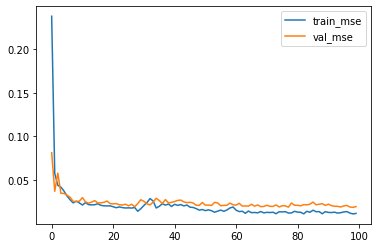

In [11]:
# Plot the cost function at each itteration
# Note: model.fit() returns an object that contains the history of the training process
plt.plot(result.history['loss'], label='train_mse');
plt.plot(result.history['val_loss'], label='val_mse');
plt.legend();

### Make forecasts (using the right way)
The right way is to use predicted data (instead of actual data) for multi-step forecasts.

In [13]:
# create the lists
validation_target = y_test
data_for_next_prediction = X_test[0]
validation_predictions = []

# start index at 0
i = 0

# make predictions
while len(validation_predictions) < len(validation_target):
    # Make prediction using available data (including predicted data)
    prediction = model.predict(data_for_next_prediction.reshape(1,-1, 1))[0,0] # need to reshape for to get it into the right format
    
    # Use the last 10 data points for the next prediction
    data_for_next_prediction = np.roll(data_for_next_prediction, -1)
    data_for_next_prediction[-1] = prediction
    
    # Add prediction to set of predictions
    validation_predictions.append(prediction)

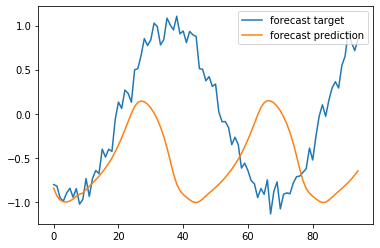

In [14]:
# plot predicted vs actual test data
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

Doesn't perform as well as the Autoregressive linear model because this RNN is too flexible. It can be shown that a linear model can perfectly model a sign wave, so an autoregressive model actually works really well for that - especially of there is no noise. 

Using activation='relu' would make it even worse. It would result in a model where the prediction is just a copy of the previous value.